# Exercise 8 - R: Anomaly Detection and Recommender Systems

<img width="350px" src="https://upload.wikimedia.org/wikipedia/commons/0/07/Two-dimensional_Outliers_Example.png">

## *Part I*: Anomaly Detection

In this section, we will determine outliers in a dataset by using a statistical approach.  Specifically, we will assume that our variables have a [Gaussian (or normal) distribution](https://en.wikipedia.org/wiki/Normal_distribution), calculate the [probability density function (PDF)](https://en.wikipedia.org/wiki/Probability_density_function) to see the relative likelihood of  that point appearing (the actual definition is a lot more nuanced since the probability of any actual point will always be 0, but that's statistics for you), and then select the cutoff value that maximizes the [F1 score](https://en.wikipedia.org/wiki/F1_score) using a validation dataset.  We will then mark any point with a probability less than our cutoff value as an outlier.

This is technically a supervised approach since we're using labeled data and a validation set, but there are a plethora of unsupervised techniques as well.  Here are a few others for example:

- **Distance/Density based approaches:** [Local outlier factor](https://en.wikipedia.org/wiki/Local_outlier_factor), [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), or [k-means](https://en.wikipedia.org/wiki/K-means_clustering)

- **Statistical approaches:** [Tukey's range test](https://en.wikipedia.org/wiki/Tukey%27s_range_test), [generalized extreme Studentized deviate (GESD)](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm), and others

We're also using the words "anomaly" and "outlier" interchangeably, but there is often debate between the terms.  Generally speaking, an outlier is a value that is extremely unlikely (an improbability), and an anomaly is an invalid value (or impossibility) that was generated by a different process altogether (which goes back into statistical theory and the importance of the data generation process).  Regardless, we're going to continue using these two terms as synonyms because we are only concerned with detecting them rather than debating their validity.

---

Beginning with package imports and data loading

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave matrices
  library(repr)  # Resizing plot sizes in Jupyter
  library(tidyverse)  # dplyr/tidyr/ggplot
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles
options(repr.plot.width=7, repr.plot.height=4.5)  # Adjusts plot sizes

Warning message:
"package 'R.matlab' was built under R version 3.3.3"Warning message:
"package 'repr' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"

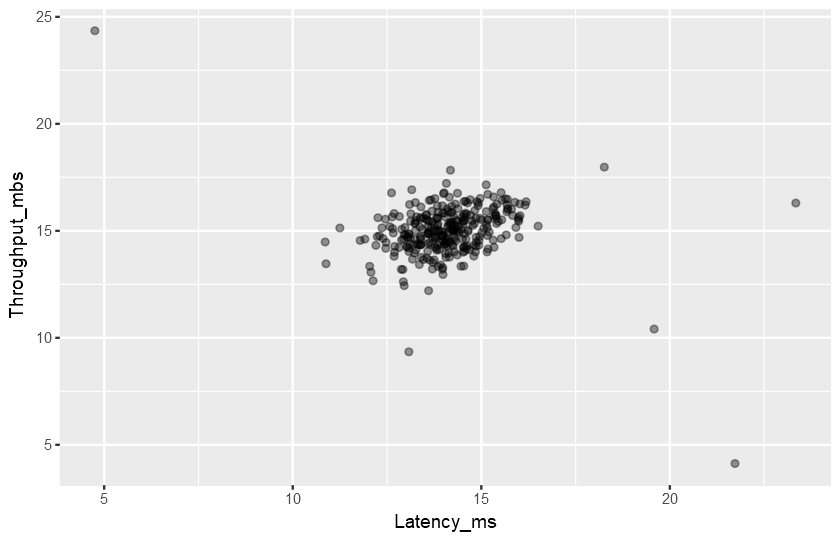

In [2]:
# Reading in data
data <- readMat('ex8/ex8data1.mat')
X <- data$X
Xval <- data$Xval
yval <- data$yval
rm(data)  # Clears from environment

# Creating a data frame for plotting
df <- data.frame(X)
colnames(df) <- c('Latency_ms', 'Throughput_mbs')

# Plotting the data
ggplot(df) +
  geom_point(aes(x=Latency_ms, y=Throughput_mbs), alpha=0.4)

### Gaussian Distribution

Before performing anomaly detecting, we need to fit a model to the data's distribution.

Estimate the Gaussian distribution for each of the features $x_i$.  For each feature $i=1 \dots n$, find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, \dots, x_i^{(m)}\}$ (the $i$-th dimension of each example)

The Gaussian distribution is given by
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e ^ {-\frac{(x - \mu)^2}{2 \sigma^2}}
\\
\mu: \text{Mean}
\\
\sigma^2: \text{Controls the variance}$$

### Estimating Gaussian parameters

In order to estimate the parameters $(\mu_i, \sigma_i^2)$, of the $i$-th feature, we will use the following equations for the mean and variance:

$$\text{Mean: } \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}
\\
\text{Variance: } \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [3]:
estimate_gaussian <- function(X) {
  # Takes the matrix X as an input and outputs:
  # mu: n-dimensional vector that holds the mean of all the n features
  # sigma2: n-dimensional vector that holds the variance of all features
  
  mu <- colMeans(X)
  sigma2 <- apply(X, 2, var)
  return(list('mu' = mu, 'sigma2' = sigma2))
}


estimate_gaussian(X)

$mu
[1] 14.11223 14.99771

$sigma2
[1] 1.838620 1.715333

Next, we'll plot the contour plot using our obtained mean and variance values

I borrowed some code from [kaleko's notebook](https://github.com/kaleko/CourseraML/blob/master/ex8/ex8.ipynb) in order to generate the contour plot (if you're reading this, thank you!)

### Selecting the threshold $\epsilon$

With the Gaussian parameters, we can see which points are more or less likely to be outliers according to their probabilities in the distribution.  We can determine the threshold for outliers with the cross validation set.

We'll do this by optimizing the $F_1$ score on the cross validation set.  As a reminder, the $F_1$ score is a mix of precision and recall:

$$F_1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$

and precision and recall are calculated as follows:

$$precision = \frac{True Positive}{True Positive + False Positive}
\\
recall = \frac{True Positive}{True Positive + False Negative}$$

In [4]:
select_threshold <- function(X, Xval, yval) {
  # Selects the threshold for determining outliers according to which
  # value minimizes the F1 score on the validatino set
  # Returns the threshold and the F1 score
  
  # Creating variables to be replaced
  optimalEpsilon <- 0
  optimalF1 <- 0
  
  # Generating the probability of the point according to the distribution
  params <- estimate_gaussian(X)
  mu <- params$mu
  sigma2 <- params$sigma2
  # probability <- matrix(0, dim(Xval)[1], dim(Xval)[2])
  probability <- dnorm(Xval, mu, sigma2)
  
  # Trying different cutoff values and evaluating the f1 score
  for (epsilon in seq(min(probability), max(probability),
                      length.out = 1000)) {
    prediction <- probability < epsilon
    
    # Calculating true/false positives/negatives
    truePositive <- sum((yval[, ] == 1) & (prediction == 1))
    falsePositive <- sum((yval[, ] == 0) & (prediction == 1))
    falseNegative <- sum((yval[, ] == 1) & (prediction == 0))
    
    # Calculating the F1 score
    precision <- truePositive / (truePositive + falsePositive)
    recall <- truePositive / (truePositive + falseNegative)
    f1 <- (2 * precision * recall) / (precision + recall)
    
    # Replacing optimal F1/epsilon if a higher value was found
    if (!is.na(optimalF1) && !is.na(f1) && optimalF1 < f1) {
      optimalEpsilon <- epsilon
      optimalF1 <- f1
    }
  }
  return(list("f1" = optimalF1, "epsilon" = optimalEpsilon))
}


results <- select_threshold(X, Xval, yval)
results

$f1
[1] 0.7142857

$epsilon
[1] 0.009777896

Now that we have our cutoff, let's assign it to our data set and plot the results

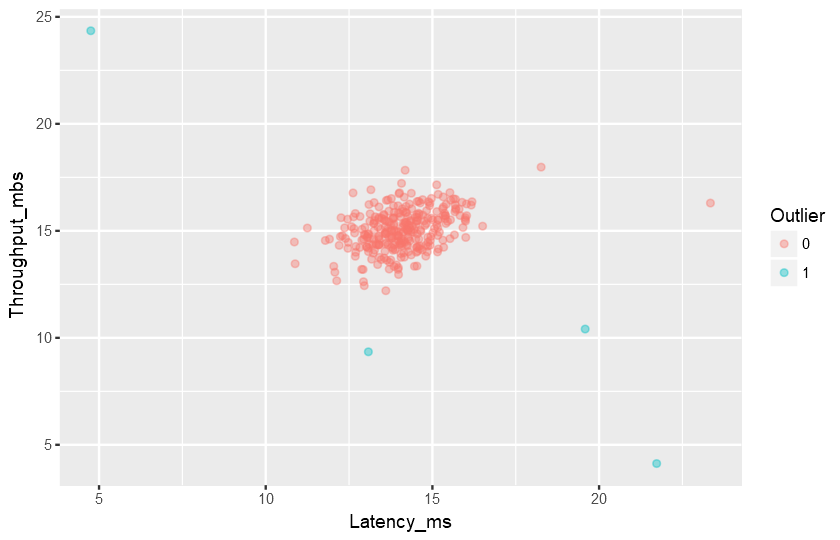

In [5]:
# Assigning Gaussian estimates to variables
mu <- estimate_gaussian(X)$mu
sigma2 <- estimate_gaussian(X)$sigma

# Calculating the probability density for the original points
df$LatencyProb <- pnorm(df$Latency_ms, mu[1], sigma2[1])
df$ThroughputProb <- pnorm(df$Throughput_mbs, mu[2], sigma2[2])

# Assigning outliers based on our obtained epsilon
df$Outlier <- ifelse((df$LatencyProb < results$epsilon) | (df$ThroughputProb < results$epsilon), 1, 0)
df$Outlier <- as.factor(df$Outlier)

# Plotting the data with outliers
ggplot(df) +
  geom_point(aes(x=Latency_ms, y=Throughput_mbs, color=Outlier), alpha=0.4)

**[Comment on outliers]**

### High dimensional dataset

This last section of part I does the same things on a dataset that is much more similar to a realistic scenario.  We won't be able to plot this without using a dimensionality reduction algorithm like [$t$-SNE](https://distill.pub/2016/misread-tsne/), but we can at least view our acquired $\epsilon$ and F1 score

In [6]:
# Reading in data
data <- readMat('ex8/ex8data2.mat')
X <- data$X
Xval <- data$Xval
yval <- data$yval
rm(data)  # Clears from environment

# Calculating the parameters of the variables
params <- estimate_gaussian(X)
mu <- params$mu
sigma2 <- params$sigma2
print(params)

# Calculating the cutoff and F1 score
results <- select_threshold(X, Xval, yval)
results

$mu
 [1]   4.939400  -9.637268  13.814707 -10.464489  -7.956229  10.199504
 [7]  -6.019408   7.969829  -6.253182   2.324513   8.473723

$sigma2
 [1] 61.03593 53.25898 58.57404 84.28833 65.33393 89.66454 55.68919 87.24959
 [9] 29.65893 70.85606 50.55412



$f1
[1] 0.1855956

$epsilon
[1] 0.006476572

---

## *Part II*: Recommender Systems

In this section, we'll use [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate movie recommendations for users.  More specifically, for each user, we will predict ratings for unrated movies based on how similar users (who gave similar ratings to the same movies as the user in question) rated these movies.  That sentence is a little dense, so a more intuitive way of explaining it is using Amazon's language of "users who liked movie A also liked movie B".

### Moving ratings dataset

I attended the University of Minnesota for grad school, and they are responsible for curating an extremely popular dataset for recommender systems: [MovieLens](https://en.wikipedia.org/wiki/MovieLens).  *Every single professor* talked about it, and I had to sit through countless presentations of student groups using it for projects.  I thought I was finally done with movie ratings and recommender systems, but here we go again.

We have a few things going on with the data we're reading in here:

- **X:** A matrix of features for the movies (ex. genre, actors, directors, etc.).  Each row is a movie, and each column is a feature.  

- **Y:** A matrix of the ratings users provided for movies.  Each row is a user, each column is a movie, and each value is the rating.

- **R:** A matrix of binary flags for if a user provided a rating for a given movie.  This goes along with the Y matrix since we aren't using null values.  Additionally, we want to predict the ratings that users will give the movies they haven't yet rated.

- **$\Theta$:** A matrix of weights provided for the features in X.



$n_u$ = 943 users

$n_m$ = 1682 movies

X = $n_m \times 100$ matrix

$\Theta$ = $n_u \times 100$ matrix

In [7]:
# Reading in the ratings
data <- readMat('ex8/ex8_movies.mat')
R <- data$R
y <- data$Y
rm(data)  # Clears from environment

# Reading in the features
data <- readMat('ex8/ex8_movieParams.mat')
theta <- data$Theta
X <- data$X
rm(data)  # Clears from environment

cat('R & y:', dim(R), 
    '\nX & Theta:', dim(X))

R & y: 1682 943 
X & Theta: 1682 10

The Octave code provided for this exercise plots the y variable to view the distribution of ratings:

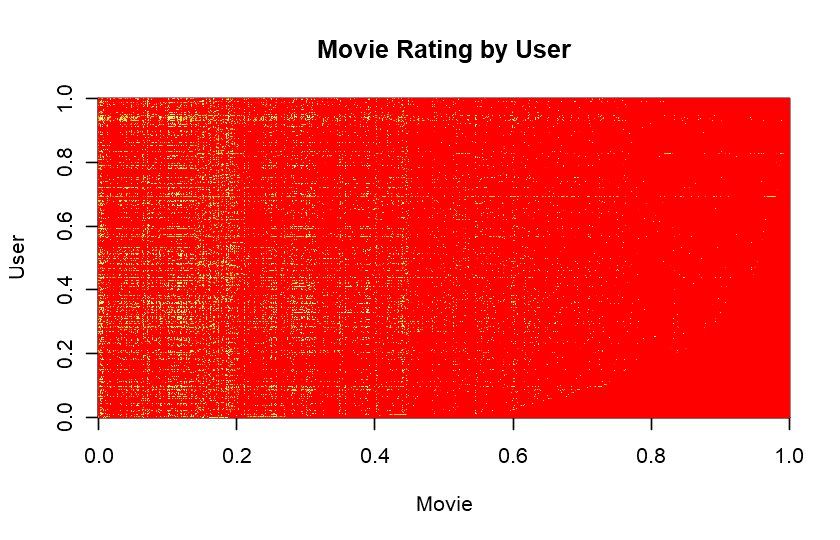

In [8]:
image(y, xlab='Movie', ylab='User')
title('Movie Rating by User')

### Collaborative Filtering

[Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a way of using "wisdom of the crowd" to recommend items.  More specifically, it recommends items to individuals by finding highly rated items from other users who rated other items similarly to that individual.

Before we can learn the parameter vectors that produce the best fit (minimize the squared error), we need to compute the cost function and the gradient for collaborative filtering.  

Additionally, we're running into the same issue as exercise 4 where SciPy's optimize function doesn't accept multidimensional parameters, so we have to provide our parameters as a vector to our functions.  However, this has to be a *single* vector, so we have to provide our multiple parameters as one into our cost and gradient function.

In order to assist with this, we'll create a few helper functions to flatten and reshape our parameters.

#### Collaborative Filtering Cost Function

$$J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}) = \frac{1}{2} \sum_{(i, j):r(i, j) = 1} (\theta^{(j)})^T x^{(i)} -y^{(i, j)})^2$$

As a reminder, the subtext of the summation symbol is telling us to only calculate the cost if the user has rated the movie.

According to the exercise, our cost should be around 22.22.

#### Collaborative Filtering Gradient

$$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})\theta_k^{(j)}
\\
\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})x_k^{(i)}$$

#### Regularized Cost Function

Now that we have our unregularized cost function and gradient, let's add the regularization terms:

$$J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}) = \frac{1}{2} \sum_{(i, j):r(i, j) = 1} (\theta^{(j)})^T x^{(i)} -y^{(i, j)})^2 +
\Big( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (\theta_k^{(j)})^2 \Big) +
\Big( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n (x_k^{(i)})^2 \Big)$$

According to the exercise, our cost should be around 31.34.

#### Regularized Gradient

$$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})\theta_k^{(j)} + \lambda x_k^{(i)}
\\
\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})x_k^{(i)} + \lambda \theta_k^{(j)}$$

### Learning Movie Recommendations

Now that we built our cost function and gradient, we'll add a user with their own movie preferences, learn the parameters (rather than using the already provided ones), and then predict movie ratings for our new user.

We'll begin by adding our new user along with their movie preferences.

Next, we'll add this new user to our data set and train the model.

One thing to note here is that we are going to "normalize" our ratings ($y$) by subtracting each user's mean rating from all of their movies that contain ratings.  This will help account for how users rate movies differently by finding their baseline and only looking at how ratings deviate from it.

Now that we have trained our model, let's look at the top 10 predictions for our user!

And that's it!  If you followed along, I hope you enjoyed the ride.  I plan on doing the same thing with a deep learning MOOC, and I'll put the exercises in the same folder if you're interested.

I plan on writing a blog post to my [github pages](https://jeffmacaluso.github.io/) about this experience after finishing the rest of the exercises in R and Julia.  I'll update this section with a link to it after I do so, but feel free to raise an issue if you see it on my github pages and I haven't added the link to it here. 